# NextstepRNN

Predict the next position (x,y) given the last position and the latent state of a RNN cell.

## ToDos:

* data augmentation: tracks zerschneiden in tracklets? Wäre sinnvoll für data association, wenn ein Teilchen in der Mitte auftaucht
* does the Masking work?
* initial_state lernen
* MLP reintrainieren
* box plots for all data, to compare with Tobias
* curriculum learning
* use `padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, padding='post')` for padding


In [2]:
# pin the tensorflow version
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
# !rm -rf ./logs/ 
logdir = './logs/'

# matplotlib rendering
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import sys
!{sys.executable} -m pip -q install pandas
!{sys.executable} -m pip -q install sklearn
!apt-get -q install wget

In [3]:
import os
import io
import glob
import random
import time
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime

print('Tensorflow version:', tf.__version__)

tf.test.is_gpu_available()
plt.rcParams['figure.figsize'] = [20, 10]

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0


In [4]:
# Load the data and unzip quietly
!wget -N https://pollithy.com/Pfeffer.zip
!unzip -q -u Pfeffer.zip

--2019-11-19 16:21:15--  https://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘Pfeffer.zip’ not modified on server. Omitting download.



In [5]:
# DATA LOADING
#
# The downloaded folder contains .csv-files which contain two columns per track.
# for example "TrackID_4_X" and "TrackID_4_Y".
# The code in this cell loads the tracks from the files and puts them into a 
# zero padded tensor with the shape: [num_tracks, num_time_steps, input_dim*2]
# Note: The "shifted" versions of the file seem to use one timestamps at a row.
#       This is not interesting for us.
#
# For every timestep the tensor contains: [x_t, y_t, x_{t+1}, y_{t+1}] where
#  t is the time step. 

# data loading parameter
num_time_steps = 35 # ToDo: Evaluate max length. 50
nan_value = 0
input_dim = 2

# collect all tracks from the files
tracks = []

file_list = sorted(glob.glob('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv'))

for file_ in file_list:
  # read the tracks from one measurement
  df = pd.read_csv(file_)
  # remove columns with less then 6 detections (same as Tobias did)
  df.dropna(axis=1, thresh=6, inplace=True)
  # there are two columns per track, for example "TrackID_4_X" and "TrackID_4_Y"
  number_of_tracks = int((df.shape[1]) / 2)

  # We wan't to use 0.0 as NaN value. Therefore we have to check that it does not
  #   exist in the data.   Note: the double .min().min() is necessary because we
  #   first get the column minima and then we get the table minimum from that
  assert df.min().min() > 0.0, f"Error: The dataframe {file_} contains a minimum <= 0.0"

  # for every track we create:
  #  x, y, x_target, y_target zero padded
  for track_number in range(number_of_tracks):
    x = df.iloc[:, (2 * track_number)].to_numpy(copy=True)
    x = np.concatenate((x[:-1], np.array([nan_value])))
    y = df.iloc[:, (2 * track_number + 1)].to_numpy(copy=True)
    y = np.concatenate((y[:-1], np.array([nan_value])))
    
    # remove the last input because we have no target for it
    last_index = np.where(np.isnan(x))[0][0] - 1
    x[last_index] = np.nan
    y[last_index] = np.nan

    # the ground truth where to particle will be afterwards
    x_target = np.concatenate( ( df.iloc[:, (2 * track_number)].to_numpy(copy=True)[1:], np.array([nan_value]) ) )
    y_target = np.concatenate( ( df.iloc[:, (2 * track_number + 1)].to_numpy(copy=True)[1:], np.array([nan_value]) ) )

    input_matrix = np.vstack((x, y, x_target, y_target))
    input_matrix = np.nan_to_num(input_matrix, nan=nan_value)
    input_matrix = input_matrix

    # initialize the array with zeros
    matrix = np.zeros([num_time_steps, input_dim*2])

    # insert the data of the track into the zero "black" background
    matrix[0:x.size, 0:input_dim*2] = input_matrix.T

    tracks.append(matrix)

tracks = np.array(tracks)
print(tracks.shape)

(6963, 35, 4)


In [6]:
# Normalization
#
# For later use we have to store x_max and y_max in order to 
# apply and revert normalization. It might also be enough to
# set constant values like 2500 and 2000.

# normalize (x distinct of y)
x_max = np.nanmax(tracks[:, :, [0, 2]])
y_max = np.nanmax(tracks[:, :, [1, 3]])
print(f'x_max: {x_max} and y_max: {y_max}')

# now all values are in [0, 1.0]
tracks[:, :, [0, 2]] /= x_max
tracks[:, :, [1, 3]] /= y_max

x_max: 2181.72 and y_max: 1678.9327


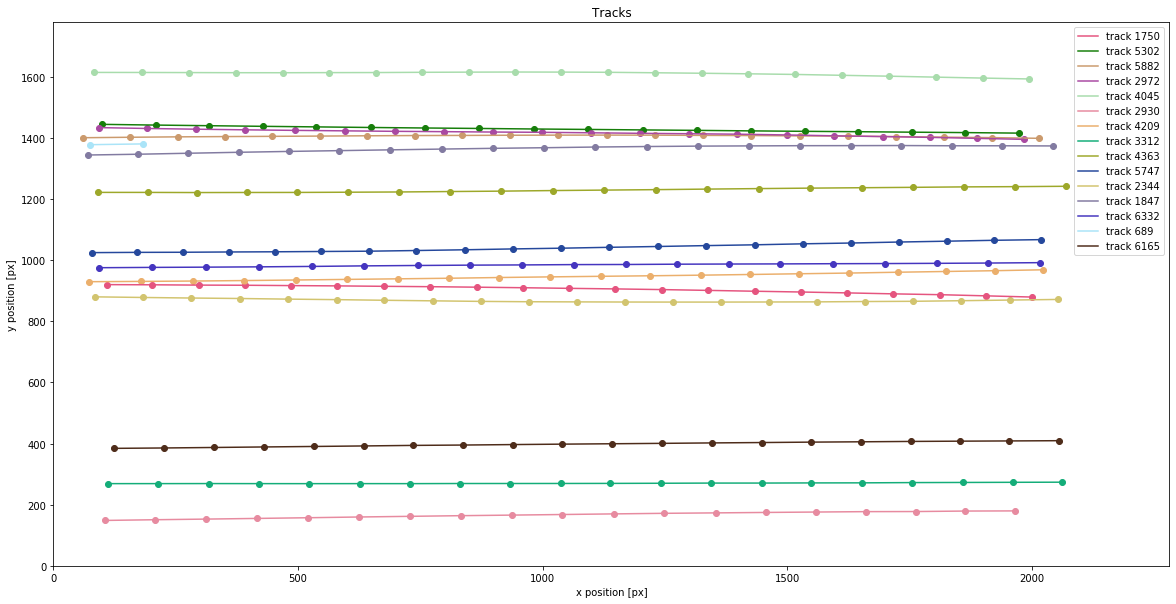

In [7]:
# track visualization
def plot_track(track, color='black', start=0, end=-1, label='track'):
    track = track[start:end]

    axes = plt.gca()
    axes.set_xlim([0, x_max + 100])
    axes.set_ylim([0, y_max + 100])

    plt.xlabel('x position [px]')
    plt.ylabel('y position [px]')
    axes.scatter(track[:, 1] * x_max, track[:, 0] * y_max, color=color)
    axes.plot(track[:, 1] * x_max, track[:, 0] * y_max, color=color, label=label)
    axes.legend()

    return axes

def get_last_timestep_of_track(track):
    for i in range(track.shape[0]):
        if not np.any(track[i]):
            return i
    return i
  
for _ in range(15):
    random_index = random.randint(0, tracks.shape[0] - 1)
    random_track = tracks[random_index]
    axes = plot_track(random_track, color=np.random.rand(3), 
                    end=get_last_timestep_of_track(random_track),
                    label=f'track {random_index}')
    plt.title(f'Tracks')
plt.show()

In [8]:
# split into train and test splits
test_split_size = 0.1

train_tracks, test_tracks = train_test_split(tracks, test_size=test_split_size)

In [9]:
# Tensorflow Dataset API

# Training examples
batch_size = 128

raw_train_dataset = tf.data.Dataset.from_tensor_slices(train_tracks)
raw_test_dataset = tf.data.Dataset.from_tensor_slices(test_tracks)

# for optimal shuffling the shuffle buffer has to be of the size of the number
# of tracks
minibatches_train = raw_train_dataset.shuffle(train_tracks.shape[0]).batch(batch_size, drop_remainder=True)
minibatches_test = raw_test_dataset.shuffle(test_tracks.shape[0]).batch(batch_size, drop_remainder=True)

# We want to train the RNN to solve a Seq2Seq problem:
# For each sequence:
#  - duplicate it
#  - and shift it to form the input and target sequence
#    by using the map method

def split_input_target(chunk):
    # split the tensor (x, y, x_target, y_target) 
    #  -> into two tensors (x, y) and (x_target, y_target)
    input_seq =  chunk[:, :, :2]
    target_seq = chunk[:, :, 2:]
    return input_seq, target_seq

dataset_train = minibatches_train.map(split_input_target)
dataset_test = minibatches_test.map(split_input_target)

In [10]:
# data augmentation on the training data

@tf.function
def augment(input_seq: tf.Tensor, target_seq:tf.Tensor) -> tf.Tensor:
    # ToDo: what makes sense and does not destroy the masking?
    random_float = tf.random.normal([1], mean=1.0, stddev=0.1, dtype=tf.float64)
    return input_seq * random_float, target_seq * random_float

# dataset_train.map(augment)

In [11]:
# HParams Dashboard for Tensorboard
# -> used for hyperparameter optimization

# *Attention:* If something is changed here, then a new directory for logging is necessary
#    because HParams cannot adapt dynamically to chaning HParams

HP_NUM_UNITS_FIRST_LSTM = hp.HParam('num_units_first_lstm', hp.Discrete([4, 16]))
HP_NUM_UNITS_SECOND_LSTM = hp.HParam('num_units_second_lstm', hp.Discrete([0, 16]))
HP_NUM_UNITS_THIRD_LSTM = hp.HParam('num_units_third_lstm', hp.Discrete([0, 16]))
HP_NUM_UNITS_FOURTH_LSTM = hp.HParam('num_units_fourth_lstm', hp.Discrete([0, 16]))
LSTM_LAYERS = [HP_NUM_UNITS_FIRST_LSTM, HP_NUM_UNITS_SECOND_LSTM, HP_NUM_UNITS_THIRD_LSTM, HP_NUM_UNITS_FOURTH_LSTM]

HP_NUM_UNITS_FIRST_DENSE = hp.HParam('num_units_first_dense', hp.Discrete([16, 32]))
HP_NUM_UNITS_SECOND_DENSE = hp.HParam('num_units_second_dense', hp.Discrete([0, 32]))
HP_NUM_UNITS_THIRD_DENSE = hp.HParam('num_units_third_dense', hp.Discrete([0, 16]))
HP_NUM_UNITS_FOURTH_DENSE = hp.HParam('num_units_fourth_dense', hp.Discrete([0, 8]))
DENSE_LAYERS = [HP_NUM_UNITS_FIRST_DENSE, HP_NUM_UNITS_SECOND_DENSE, HP_NUM_UNITS_THIRD_DENSE, HP_NUM_UNITS_FOURTH_DENSE]

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
LEAKY_RELU_ALPHA = hp.HParam('leaky_relu_alpha', hp.Discrete([0.2]))
DENSE_BATCH_NORM = hp.HParam('use_batchnorm_on_dense', hp.Discrete([True]))
LR_DECAY_AFTER_EPOCHS = hp.HParam('lr_decay_after_epochs', hp.Discrete([100]))

METRIC_MSE = 'mse'

ALL_HPARAMS = [HP_OPTIMIZER, LEAKY_RELU_ALPHA, DENSE_BATCH_NORM, LR_DECAY_AFTER_EPOCHS] + LSTM_LAYERS + DENSE_LAYERS

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=ALL_HPARAMS,
        metrics=[hp.Metric(METRIC_MSE, display_name='MSE')],
    )

In [12]:
# model factory
def model_factory(hparams):
    model = tf.keras.Sequential()

    # The Masking makes the model ignore timesteps where the whole vector
    # consists of the *mask_value* 
    model.add(tf.keras.layers.Masking(mask_value=nan_value, name="masking_layer", 
                                      batch_input_shape=(batch_size, num_time_steps, input_dim)))
    
    # Add the LSTM layers
    for lstm_layer in LSTM_LAYERS:
        if hparams[lstm_layer] == 0:
            # as soon as one layer has no units, we don't create the layer.
            break
        else:
            model.add(tf.keras.layers.LSTM(hparams[lstm_layer], 
                                            return_sequences=True, 
                                            stateful=False, 
                                            unroll=True,
                                            recurrent_initializer='glorot_uniform'))
    
    # Add the dense layers
    for dense_layer in DENSE_LAYERS:
        if hparams[dense_layer] == 0:
            # as soon as one layer has no units, we don't create the layer.
            break
        else:
            model.add(tf.keras.layers.Dense(hparams[dense_layer]))
            model.add(tf.keras.layers.LeakyReLU(alpha=hparams[LEAKY_RELU_ALPHA]))
            if hparams[DENSE_BATCH_NORM]:
                model.add(tf.keras.layers.BatchNormalization())    
    
    # Always end with a dense layer with two outputs (x, y)
    model.add(tf.keras.layers.Dense(2))

    return model


In [13]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

reduce_learning_rate_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',  # usually val_loss is used but as they do not really differ we can also use the loss directly
    verbose=1,  # show update messages
    factor=0.1,
    patience=10, 
    min_lr=0.000001)

In [19]:
%tensorboard --logdir logs --host 0.0.0.0 --port 6006

Reusing TensorBoard on port 6006 (pid 2532), started 0:00:39 ago. (Use '!kill 2532' to kill it.)

In [14]:
# make some graphics to evaluate qualitatively
def plot_tracks(n=5, step=1):
    for input_example_batch, target_example_batch in dataset_test.take(1):
        # hidden = model.reset_states()
        example_batch_predictions = model(input_example_batch)
        for i in range(n):
            seq_length = get_last_timestep_of_track(input_example_batch[i])
            axes = plot_track(input_example_batch[i], color='black', end=seq_length, label=f"Input truth {i}")
            axes = plot_track(target_example_batch[i], color='green', end=seq_length, label=f"Output truth {i}")
            axes = plot_track(example_batch_predictions[i], color='blue', end=seq_length, label=f"NextStep-RNN {i}")
            plt.title(f'Track with predictions [test data]')

        # store plot in memory buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # add batch dim
        image = tf.expand_dims(image, 0)
        tf.summary.image("plot", image, step=step)

        plt.show()

In [15]:
# IMPORTANT:
# The NextStep-RNN only worked if it was supplied with 4 initial data points.
# -> but the first predictions were the hardest. Therefore the error is much
#    higher at the beginning.
# Therefore I created the following evaluation which ignores the first four
#  predictions in order to compare our results with results of Tobias.
#
# In this "benchmark" we would calculate the loss as we did because the network
#  focuses on minimizing the large loss of the first time steps.
#  -> we don't change this, because predicting the first timesteps is our main goal.

# ToDo: write TF code for this

def calculate_mse_test(model, dataset):
    mses = []

    it = -1

    # at which step to start evaluation
    seq_start = 4 # 4
    
    sum_mse = 0
    sum_num_items = 0

    for input_example_batch, target_example_batch in dataset:
      it += 1
      hidden = model.reset_states()
      example_batch_predictions = model(input_example_batch)

      for i in range(example_batch_predictions.shape[0]):
        seq_end = get_last_timestep_of_track(input_example_batch[i])

        if seq_end <= seq_start:
          continue

        y_correct = target_example_batch[i][seq_start:seq_end].numpy()
        y_correct[:, 0] *= x_max
        y_correct[:, 1] *= y_max

        y_predicted = example_batch_predictions[i][seq_start:seq_end].numpy()
        y_predicted[:, 0] *= x_max
        y_predicted[:, 1] *= y_max

        mse = np.linalg.norm(y_correct - y_predicted, axis=1, ord=2)
        # mses.append(np.mean(mse))   
        
        sum_mse += np.mean(mse)
        sum_num_items += 1

    # return np.mean(mses)
    return sum_mse / sum_num_items

In [16]:
# Custom training

def train_step_generator():
    
    # the placeholder character used for padding
    mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
    
    @tf.function
    def train_step(inp, target):
        with tf.GradientTape() as tape:
            target = K.cast(target, tf.float64)
            predictions = model(inp)

            mask = K.all(K.equal(target, mask_value), axis=-1)
            mask = 1 - K.cast(mask, tf.float64)
            mask = K.cast(mask, tf.float64)

            # multiply categorical_crossentropy with the mask
            loss = tf.keras.losses.mean_squared_error(target, predictions) * mask

            # take average w.r.t. the number of unmasked entries
            loss = K.sum(loss) / K.sum(mask)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return loss
    
    return train_step

In [17]:
def get_name_for_experiment():
    now = datetime.now() # current date and time
    datetime_string = now.strftime("%Y-%m-%d--%H-%M-%S")
    return datetime_string

In [ ]:
EPOCHS = 200
EVAL_EVERY_NTH_EPOCH = 50

num_experiment = 0
total_num_experiments = len(list(itertools.product(*[param.domain.values for param in ALL_HPARAMS])))

# iterate over all possible hyperparameter combinations
for hparam_values in itertools.product(*[param.domain.values for param in ALL_HPARAMS]):
    # parameters of current run: dict(HPARAM -> value)
    hparams = dict(zip(ALL_HPARAMS, hparam_values))

    run_name = get_name_for_experiment()
    print(f'--- Starting experiment {num_experiment}/{total_num_experiments}: {run_name}')
    print({h.name: hparams[h] for h in hparams})
    run_dir = 'logs/hparam_tuning/' + run_name

    step = 0

    # run the training and evaluation for one model
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial

        model = model_factory(hparams)
        # print(model.summary())
        train_step = train_step_generator()

        # optimizer = 'adam'  # tf.keras.optimizers.Adam(learning_rate=hparams[HP_INITIAL_LR])
        optimizer = tf.keras.optimizers.Adam()

        for epoch in range(EPOCHS):
            # initializing the hidden state at the start of every epoch. initally hidden is None
            hidden = model.reset_states()

            # learning rate decay
            if (epoch+1) % hparams[LR_DECAY_AFTER_EPOCHS] == 0:
                old_lr = K.get_value(optimizer.lr)
                new_lr = old_lr * 0.1
                # print(f"Reducing learning rate from {old_lr} to {new_lr}.")
                print("R", end='')
                K.set_value(optimizer.lr, new_lr)

            for (batch_n, (inp, target)) in enumerate(dataset_train):
                hidden = model.reset_states()
                loss = train_step(inp, target)                    
                step += batch_size
            # print('Epoch {}/{} Loss {}'.format(epoch+1, EPOCHS, loss))
            tf.summary.scalar('training_loss', loss, step=step)

            print(".", end='')
            
            if (epoch + 1) % EVAL_EVERY_NTH_EPOCH == 0 or (epoch + 1) == EPOCHS:
                train_mse = calculate_mse_test(model, dataset_train)
                test_mse = calculate_mse_test(model, dataset_test)

                tf.summary.scalar('mse_train', train_mse, step=step)
                tf.summary.scalar('mse_test', test_mse, step=step)
                tf.summary.scalar('learning_rate', K.get_value(optimizer.lr), step=step)
                # plot_tracks(step=step)
                
                print("E", end='')

                tf.summary.scalar(METRIC_MSE, calculate_mse_test(model, dataset_test), step=1)
                # model.save_weights(checkpoint_prefix.format(epoch=epoch))
    print("")
    num_experiment += 1
        
    # clear after training
    K.clear_session()  
        


--- Starting experiment 0/256: 2019-11-19--16-21-33
{'optimizer': 'adam', 'leaky_relu_alpha': 0.2, 'use_batchnorm_on_dense': True, 'lr_decay_after_epochs': 100, 'num_units_first_lstm': 4, 'num_units_second_lstm': 0, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 16, 'num_units_second_dense': 0, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0}
..................................................E.................................................R.E...........................